v \# AIAM

# Dataset

Detecting Anomalies in Wafer Manufacturing

# About Dataset

Overview
Detecting Anomalies can be a difficult task and especially in the case of labeled datasets due to some level of human bias introduced while labeling the final product as anomalous or good. These giant manufacturing systems need to be monitored every 10 milliseconds to capture their behavior which brings in lots of information and what we call the Industrial IoT (IIOT). Also, hardly a manufacturer wants to create an anomalous product. Hence, the anomalies are like a needle in a haystack which renders the dataset that is significantly Imbalanced.

Capturing such a dataset using a machine learning model and making the model generalize can be fun. In this competition, we bring such a use-case from one of India's leading manufacturers of wafers(semiconductors). The dataset collected was anonymized to hide the feature names, also there are 1558 features that would require some serious domain knowledge to understand them.

However, In the era of Deep Learning, we are challenging the data science community to come up with an anomaly detection model that can generalize well on the unseen set of data(Test data). In this hackathon, you will be creating a machine learning/ deep learning model to classify the anomalies correctly using Area under the curve(AUC) as metric.

# Context

Semiconductors are the core components of modern electronics, driving technologies essential for economic growth, national security, and global competitiveness. From smartphones to airplanes, semiconductors have advanced to enhance technologies, providing remarkable benefits for entertainment and convenience. Key industries that heavily depend on semiconductors include Computing, Telecommunications, Household Appliances, Banking, Security, Automotive/Transportation, Healthcare, and Manufacturing.

The fundamental component needed to build semiconductor devices is the wafer, a thin slice of a semiconductor material like crystalline silicon (c-Si), used in fabricating integrated circuits. While silicon is the primary material, wafers can also contain other elements.

Semiconductor manufacturers order wafers from suppliers based on their production volume and experimental needs for process and technology improvement. This dataset comes from one of India's leading wafer manufacturers, who aim to avoid producing defective products. There are two datasets: Train.csv and Test.csv. The Train.csv file includes features (without specifying their role in production) and a class label indicating whether the wafer passed or failed. The objective of this project is to develop a model that can predict wafers with anomalies.

# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

#model selection
from sklearn.model_selection import GridSearchCV, cross_val_score

#metrics
from sklearn.metrics import confusion_matrix, roc_curve

In [2]:
import pandas as pd

# Load the datasets
train_df = pd.read_csv('Train.csv')
test_df = pd.read_csv('Test.csv')
sample_submission_df = pd.read_csv('Sample_submission.csv')

In [3]:
data = pd.read_csv("Train.csv")
data.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_1550,feature_1551,feature_1552,feature_1553,feature_1554,feature_1555,feature_1556,feature_1557,feature_1558,Class
0,100,160,1.6000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,20,83,4.1500,1,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
2,99,150,1.5151,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,40,40,1.0000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,12,234,19.5000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Data Cleaning

In [4]:
data.any().isna()

feature_1       False
feature_2       False
feature_3       False
feature_4       False
feature_5       False
                ...  
feature_1555    False
feature_1556    False
feature_1557    False
feature_1558    False
Class           False
Length: 1559, dtype: bool

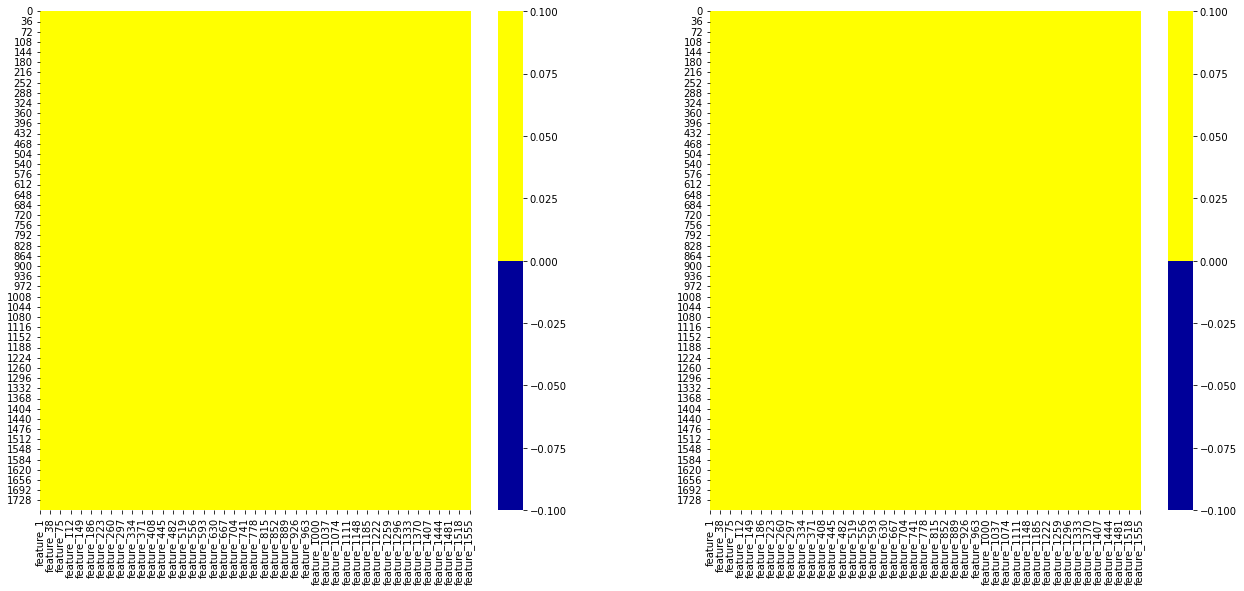

In [5]:
colours = ['#000099', '#ffff00'] # specify the colours - yellow is missing. blue is not missing.

fig, ax = plt.subplots(1,2,figsize=(20,10))
fig.tight_layout(pad=10.0)

sns.heatmap(data.isna(), ax=ax[0], cmap=sns.color_palette(colours))
sns.heatmap(data.isnull(), ax=ax[1], cmap=sns.color_palette(colours));

No Missing Value in the data

In [6]:
data.dtypes[data.columns]

feature_1         int64
feature_2         int64
feature_3       float64
feature_4         int64
feature_5         int64
                 ...   
feature_1555      int64
feature_1556      int64
feature_1557      int64
feature_1558      int64
Class             int64
Length: 1559, dtype: object

In [7]:
data.dtypes[data.columns].nunique()

2

There are 2types of values in the dataset, int64 and flaot64.

In [8]:
(data.dtypes[data.columns]=='float64').sum()

1

In [9]:
which_float = (data.dtypes[data.columns]=='float64')
which_float[which_float==True].index

Index(['feature_3'], dtype='object')

In [10]:
binary_features, categorical_features, single_value_features = [], [], []
for x in [col for col in data.columns if col not in ['feature_3','Class']]:
    number_of_categories = data[x].nunique()
    if number_of_categories==1:
        single_value_features.append(x)
    elif number_of_categories==2:
        binary_features.append(x)
    else:
        categorical_features.append(x)

In [11]:
len(binary_features) + len(single_value_features) + len(categorical_features) + 2 == data.shape[1]

True

In [12]:
len(binary_features)

1519

In [13]:
len(categorical_features)

2

In [14]:
len(single_value_features)

36

In [15]:
data[categorical_features].describe()

,feature_1,feature_2
count,1763.000000,1763.000000
mean,53.094158,126.587067
std,55.842014,129.859641
min,1.000000,1.000000
25%,12.000000,33.500000
50%,39.000000,96.000000
75%,75.000000,159.000000
max,640.000000,640.000000


<AxesSubplot:>

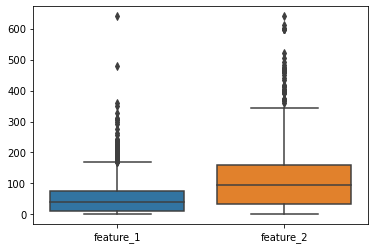

In [16]:
sns.boxplot(data = data[categorical_features])


These two variables are defined as integers, even though they are continuous. Therefore, we will combine the variables with a float data type and the categorical_features list into a single list.

In [17]:
continuous_features = categorical_features + ['feature_3']

In [18]:
data[single_value_features]

,feature_57,feature_82,feature_106,feature_147,feature_262,feature_278,feature_284,feature_320,feature_362,feature_372,...,feature_1038,feature_1063,feature_1096,feature_1185,feature_1211,feature_1243,feature_1247,feature_1341,feature_1367,feature_1407
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1758,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1759,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1760,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1761,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Value that i remove

In [19]:
data = data.drop(single_value_features, axis=1)

In [20]:
data.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_1550,feature_1551,feature_1552,feature_1553,feature_1554,feature_1555,feature_1556,feature_1557,feature_1558,Class
0,100,160,1.6000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,20,83,4.1500,1,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
2,99,150,1.5151,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,40,40,1.0000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,12,234,19.5000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
duplicated_columns = []
for x in binary_features:
    x_feature_check_with_y = []
    for y in binary_features:
        if data[x].equals(data[y])==True:
            x_feature_check_with_y.append(1)
        else:
            x_feature_check_with_y.append(0)
    duplicated_columns.append(x_feature_check_with_y)


In [22]:
duplicated_columns = pd.DataFrame(duplicated_columns, columns=binary_features, index=binary_features)
duplicated_columns

,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,...,feature_1549,feature_1550,feature_1551,feature_1552,feature_1553,feature_1554,feature_1555,feature_1556,feature_1557,feature_1558
feature_4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
feature_5,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
feature_6,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
feature_7,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
feature_8,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
feature_1554,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
feature_1555,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
feature_1556,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
feature_1557,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


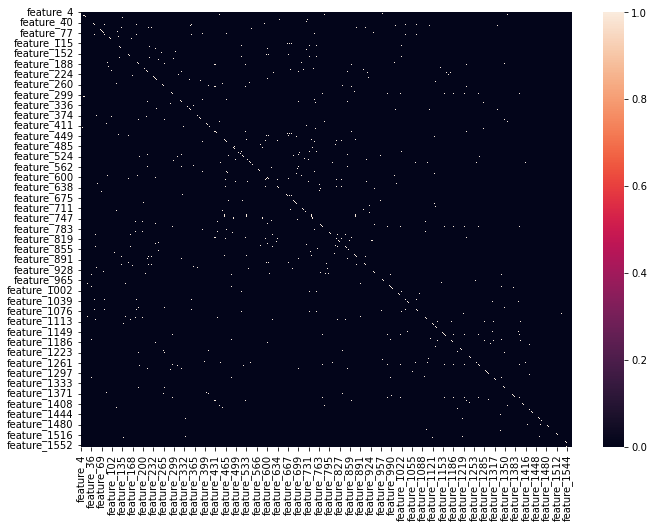

In [23]:
fig, ax = plt.subplots(1,1,figsize=(11,8))

sns.heatmap(duplicated_columns, ax=ax);

the diagonal elements are equal to 1 since each feature is being compared to itself. But, it is evident that there are significant relationships among the other elements too.

In [24]:
features_to_be_removed = []
i=0
while i<duplicated_columns.shape[0]:
    for j in range(i):
        if data[data.columns[i]].equals(data[data.columns[j]]):
            features_to_be_removed.append(data.columns[j])
    i+=1 # Convert to pandas 

In [25]:
pd.Series(features_to_be_removed).duplicated(keep=False) #Remove the columns from the dataframe

0        True
1        True
2        True
3        True
4        True
        ...  
2708    False
2709     True
2710     True
2711     True
2712    False
Length: 2713, dtype: bool

In [26]:
which_to_be_dropped = pd.Series(features_to_be_removed).drop_duplicates(keep='first')
data = data.drop(which_to_be_dropped.values, axis=1)
data.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_10,feature_13,feature_18,feature_21,feature_27,...,feature_1550,feature_1551,feature_1552,feature_1553,feature_1554,feature_1555,feature_1556,feature_1557,feature_1558,Class
0,100,160,1.6000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,20,83,4.1500,1,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,99,150,1.5151,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,40,40,1.0000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,12,234,19.5000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
data[data.duplicated(keep=False)==True] # Check for duplicate

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_10,feature_13,feature_18,feature_21,feature_27,...,feature_1550,feature_1551,feature_1552,feature_1553,feature_1554,feature_1555,feature_1556,feature_1557,feature_1558,Class
5,90,90,1.0000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,18,24,1.3333,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24,10,600,60.0000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
33,1,1,2.0000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
38,1,1,2.0000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1695,1,1,2.0000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1720,90,90,1.0000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1722,15,80,5.3333,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1723,1,1,2.0000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
data = data.drop_duplicates()
data.reset_index(inplace=True)
data = data.drop('index',axis=1)

In [29]:
binary_features = []
for x in [col for col in data.columns if col not in ['feature_1', 'feature_2', 'feature_3', 'Class']]:
    binary_features.append(x)

# EDA

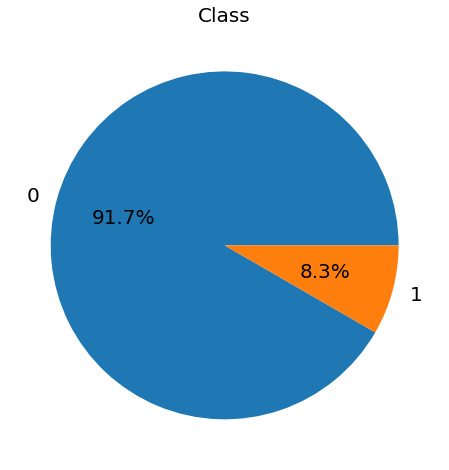

In [30]:
round((data.Class.value_counts()/data.Class.count())*100,2).plot.pie(autopct='%1.1f%%',
                                                                     figsize=(8,8), fontsize=20)
plt.title('Class', fontsize=20)
plt.ylabel('');

In [31]:
from sklearn.model_selection import train_test_split

X, y = data[binary_features], data.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

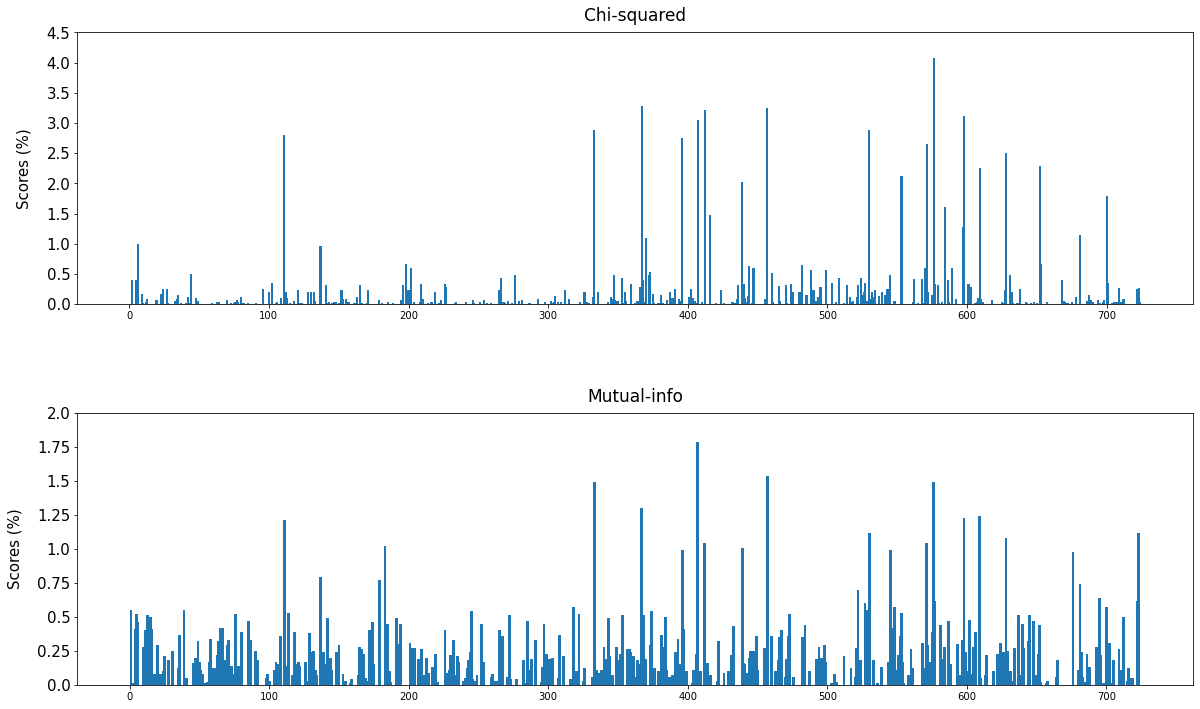

In [32]:
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif

fs_chi = SelectKBest(score_func=chi2, k='all')
fs_chi.fit(X_train, y_train)

fs_mut = SelectKBest(score_func=mutual_info_classif, k='all')
fs_mut.fit(X_train, y_train)

# check the scores function for nan values and replace to 0
fs_chi.scores_[np.isnan(fs_chi.scores_)]=0
fs_mut.scores_[np.isnan(fs_mut.scores_)]=0

scores_chi = np.around((fs_chi.scores_/fs_chi.scores_.sum())*100,2)
scores_mut = np.around((fs_mut.scores_/fs_mut.scores_.sum())*100,2) 
#calculate the scores

fig, ax = plt.subplots(2,1,figsize=(20,12))
plt.subplots_adjust(hspace=0.4)

position = np.arange(len(fs_chi.scores_))


ax[0].bar(position, scores_chi, width=1.5)
ax[0].set_yticks(ax[0].get_yticks())
ax[0].set_yticklabels(np.around(ax[0].get_yticks(),2), fontsize=15)
ax[0].set_ylabel("Scores (%)", labelpad=15, fontsize=15)
ax[0].set_title("Chi-squared", y=1.02, fontsize=17)


ax[1].bar(position, scores_mut, width=2)
ax[1].set_yticks(ax[1].get_yticks())
ax[1].set_yticklabels(np.around(ax[1].get_yticks(),2), fontsize=15)
ax[1].set_ylabel("Scores (%)", labelpad=15, fontsize=15)
ax[1].set_title("Mutual-info", y=1.02, fontsize=17)

plt.savefig('chi-squared.png')

In [33]:
data.columns[np.where(scores_chi>=1)]

Index(['feature_13', 'feature_345', 'feature_954', 'feature_1044',
       'feature_1048', 'feature_1110', 'feature_1137', 'feature_1149',
       'feature_1156', 'feature_1204', 'feature_1240', 'feature_1342',
       'feature_1370', 'feature_1392', 'feature_1397', 'feature_1405',
       'feature_1419', 'feature_1420', 'feature_1433', 'feature_1453',
       'feature_1481', 'feature_1511', 'feature_1530'],
      dtype='object')

In [34]:
data.columns[np.where(scores_mut>=1)]

Index(['feature_345', 'feature_555', 'feature_954', 'feature_1044',
       'feature_1137', 'feature_1149', 'feature_1204', 'feature_1240',
       'feature_1342', 'feature_1392', 'feature_1397', 'feature_1420',
       'feature_1433', 'feature_1453', 'feature_1553'],
      dtype='object')

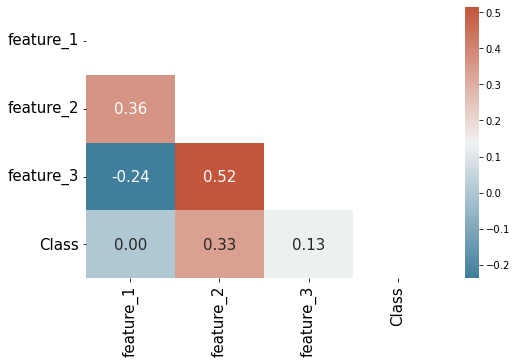

In [35]:
fig, ax = plt.subplots(1,1,figsize=(8,5))

mask = np.triu(np.ones_like(data[continuous_features + ['Class']].corr(), dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(data[continuous_features + ['Class']].corr(), annot=True, fmt='.2f', 
            mask=mask, cmap=cmap, annot_kws={'size': 15}, ax=ax)

ax.set_xticks([0.5,1.5,2.5,3.5])
ax.set_xticklabels(continuous_features + ['Class'], fontsize=15, rotation=90)
ax.set_yticks([0.5,1.5,2.5,3.5])
ax.set_yticklabels(continuous_features + ['Class'], fontsize=15, rotation=360);

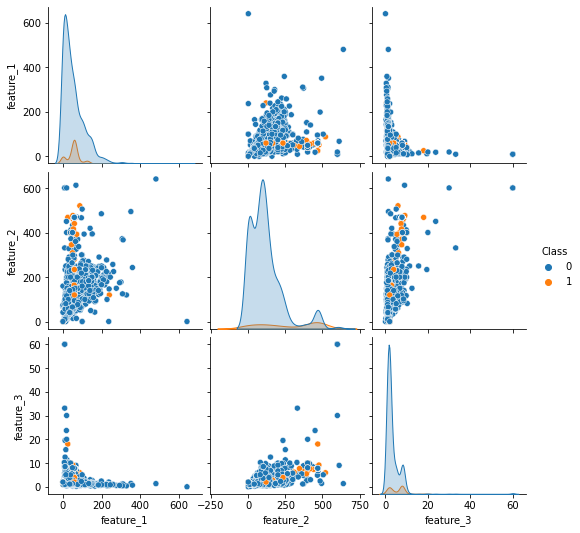

In [36]:
sns.pairplot(data[continuous_features + ['Class']], hue='Class');

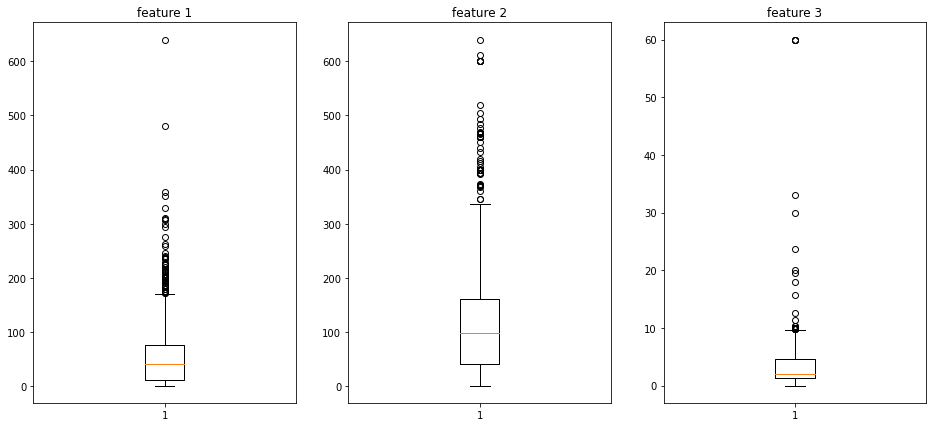

In [37]:
fig, axs =  plt.subplots(1,3,figsize = (16,7))
for i in range(3):
    axs[i].set_title(f'feature {i+1}')
    axs[i].boxplot(data[f'feature_{i+1}'])

# Predicting Anomalies

In [38]:
data_for_predictions = data[continuous_features + data.columns[np.where(scores_chi>=1)].tolist() + ['Class']]

In [39]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

ss = StandardScaler()
mm = MinMaxScaler()

for col in data_for_predictions.columns[:3]:
    ss.fit(data_for_predictions[col].to_numpy().reshape(-1,1))
    data_for_predictions[col] = ss.transform(data_for_predictions[col].to_numpy().reshape(-1,1))
    data_for_predictions[col] = mm.fit_transform(data_for_predictions[col].to_numpy().reshape(-1,1)).reshape(1,-1)[0]

C:\Users\tangk\AppData\Local\Temp\ipykernel_30960\3644616183.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_for_predictions[col] = ss.transform(data_for_predictions[col].to_numpy().reshape(-1,1))
C:\Users\tangk\AppData\Local\Temp\ipykernel_30960\3644616183.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_for_predictions[col] = mm.fit_transform(data_for_predictions[col].to_numpy().reshape(-1,1)).reshape(1,-1)[0]
C:\Users\tangk\AppData\Local\Temp\ipykernel_30960\3644616183.py:8: SettingWithC

In [40]:
data_for_predictions.head()

,feature_1,feature_2,feature_3,feature_13,feature_345,feature_954,feature_1044,feature_1048,feature_1110,feature_1137,...,feature_1397,feature_1405,feature_1419,feature_1420,feature_1433,feature_1453,feature_1481,feature_1511,feature_1530,Class
0,0.154930,0.248826,0.026642,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.029734,0.128326,0.069143,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.153365,0.233177,0.025227,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.061033,0.061033,0.016642,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.017214,0.364632,0.324983,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
data_for_predictions.describe()

,feature_1,feature_2,feature_3,feature_13,feature_345,feature_954,feature_1044,feature_1048,feature_1110,feature_1137,...,feature_1397,feature_1405,feature_1419,feature_1420,feature_1433,feature_1453,feature_1481,feature_1511,feature_1530,Class
count,1715.000000,1715.000000,1715.000000,1715.000000,1715.000000,1715.000000,1715.000000,1715.000000,1715.000000,1715.000000,...,1715.000000,1715.000000,1715.000000,1715.000000,1715.000000,1715.000000,1715.000000,1715.000000,1715.000000,1715.000000
mean,0.082927,0.199143,0.056078,0.006414,0.005831,0.009913,0.033236,0.033819,0.005248,0.165598,...,0.003499,0.005248,0.006414,0.003499,0.009329,0.006997,0.005248,0.005248,0.020991,0.083382
std,0.087919,0.202000,0.066147,0.079853,0.076160,0.099096,0.179305,0.180816,0.072273,0.371828,...,0.059062,0.072273,0.079853,0.059062,0.096165,0.083380,0.072273,0.072273,0.143397,0.276539
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.017214,0.061033,0.020809,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.061033,0.151800,0.033309,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.116588,0.250391,0.076771,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Accuracy

In [42]:
X, y = data_for_predictions.iloc[:,:-1], data_for_predictions.iloc[:,-1]

X_train, X_test, y_t
rain, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [43]:
parameters = {'penalty':['l1','l2'],
              'C': [0.001, 0.01, 0.1, 1]}
# Logistic Regression
GD_LR = GridSearchCV(LogisticRegression(solver='liblinear'),
                        param_grid=parameters, 
                        scoring='f1')

#Decision Trees
parameters = {'max_leaf_nodes': [i for i in range(2,10)],
              'max_depth': [i for i in range(2,10)]}
    
GD_DT = GridSearchCV(DecisionTreeClassifier(class_weight="balanced"),
                     param_grid=parameters, 
                     scoring='f1')

#Extra Trees
GD_ET = GridSearchCV(ExtraTreesClassifier(class_weight="balanced"),
                     param_grid=parameters, 
                     scoring='f1')

#Random Forest
GD_RF = GridSearchCV(RandomForestClassifier(class_weight="balanced"),
                     param_grid=parameters, 
                     scoring='f1')

#Gradient Boosting
GD_GB = GridSearchCV(GradientBoostingClassifier(),
                     param_grid=parameters, 
                     scoring='f1')

#k-NN
parameters = {'n_neighbors': [i for i in range(5,35,5)]}
GD_kNN = GridSearchCV(KNeighborsClassifier(),
                      param_grid=parameters, 
                      scoring='f1')


models = {'Logistic_Regression': GD_LR,
          'kNN': GD_kNN,
          'Decision_Trees': GD_DT,
          'Extra_Trees': GD_ET,
          'Random_Forest': GD_RF,
          'Gradient_Boosting': GD_GB}

In [44]:
import warnings
warnings.filterwarnings("ignore")

In [45]:
results_col = ['Classifier', 'Accuracy', 'Precision', 'Recall', 'ROC-AUC', 'F1-score']
results = pd.DataFrame(columns=results_col)

l = 0

accuracy_models_opt, precision_models_opt, recall_models_opt = [], [], []
roc_auc_models_opt, f1_score_models_opt = [], []
best_estimator = {}

for name, model in models.items():
    print(name)
    model.fit(X_train,y_train)
    
    accuracy = cross_val_score(model.best_estimator_, X, y, cv=10, scoring='accuracy')
    accuracy_models_opt.append(accuracy)    
    precision = cross_val_score(model.best_estimator_, X, y, cv=10, scoring='precision')
    precision_models_opt.append(precision)
    recall = cross_val_score(model.best_estimator_, X, y, cv=10, scoring='recall')
    recall_models_opt.append(recall)
    roc_auc = cross_val_score(model.best_estimator_, X, y, cv=10, scoring='roc_auc')
    roc_auc_models_opt.append(roc_auc)
    f1 = cross_val_score(model.best_estimator_, X, y, cv=10, scoring='f1')
    f1_score_models_opt.append(roc_auc)
    
    best_estimator[name] = model.best_estimator_
    
    results.loc[l] = [name,
                      '%s $\pm$ %s' %(round(accuracy.mean()*100,2),round(accuracy.std()*100,2)),
                      '%s $\pm$ %s' %(round(precision.mean()*100,2),round(precision.std()*100,2)),
                      '%s $\pm$ %s' %(round(recall.mean()*100,2),round(recall.std()*100,2)),
                      '%s $\pm$ %s' %(round(roc_auc.mean()*100,2),round(roc_auc.std()*100,2)),
                      '%s $\pm$ %s' %(round(f1.mean()*100,2),round(f1.std()*100,2))]
    l += 1

Logistic_Regression
kNN
Decision_Trees
Extra_Trees
Random_Forest
Gradient_Boosting


In [46]:
results

,Classifier,Accuracy,Precision,Recall,ROC-AUC,F1-score
0,Logistic_Regression,91.43 $\pm$ 0.98,47.54 $\pm$ 14.86,18.95 $\pm$ 7.96,82.68 $\pm$ 6.54,26.46 $\pm$ 9.63
1,kNN,92.01 $\pm$ 1.61,55.29 $\pm$ 11.7,39.86 $\pm$ 8.88,86.76 $\pm$ 5.87,45.31 $\pm$ 8.24
2,Decision_Trees,89.45 $\pm$ 1.99,41.85 $\pm$ 7.83,65.05 $\pm$ 10.21,79.16 $\pm$ 4.66,50.78 $\pm$ 8.45
3,Extra_Trees,90.03 $\pm$ 1.34,44.82 $\pm$ 5.63,69.19 $\pm$ 12.69,84.08 $\pm$ 5.54,52.77 $\pm$ 6.88
4,Random_Forest,89.56 $\pm$ 2.02,42.32 $\pm$ 7.07,67.14 $\pm$ 13.54,88.55 $\pm$ 4.03,53.3 $\pm$ 9.03
5,Gradient_Boosting,92.48 $\pm$ 1.15,62.13 $\pm$ 19.05,30.71 $\pm$ 9.22,87.59 $\pm$ 4.91,40.0 $\pm$ 9.86


The box above shows the accuracy of each classifier with gradient_boosting being the highest and decision_tree the lowest.

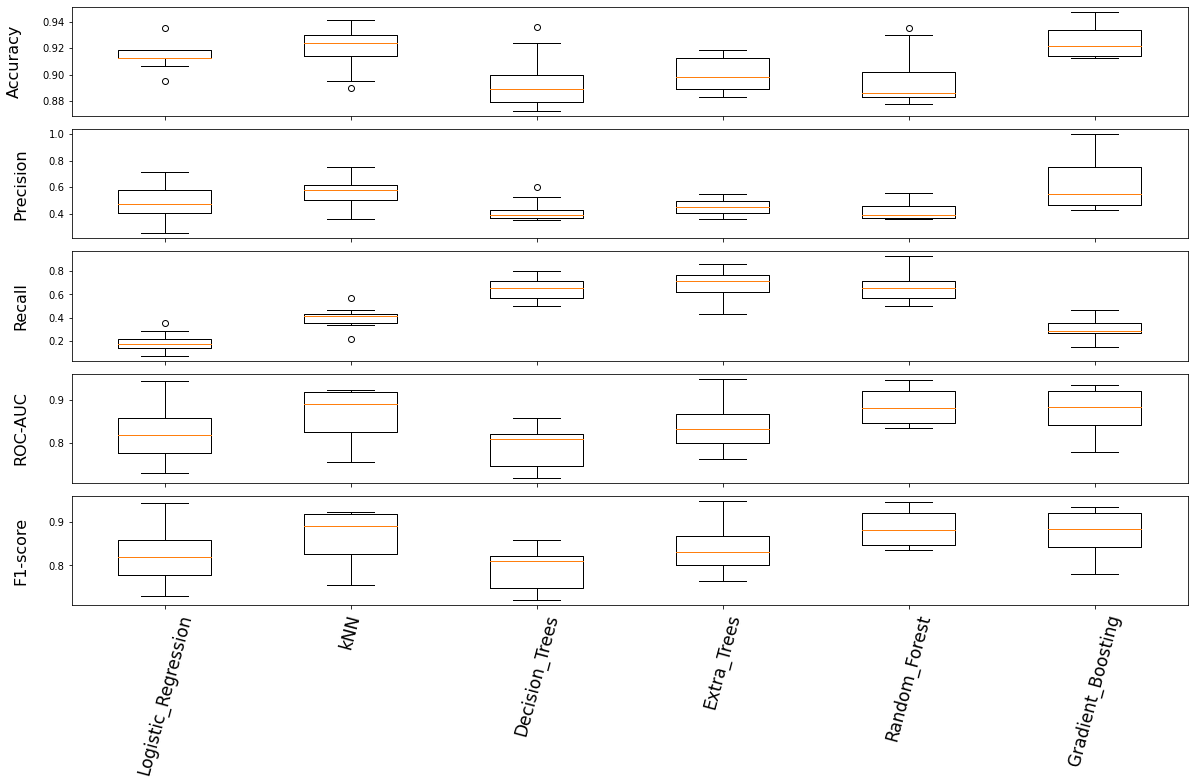

In [47]:
fig, ax = plt.subplots(5, 1, figsize=(20,11))
plt.subplots_adjust(hspace=0.12)

ax[0].boxplot(accuracy_models_opt)
ax[1].boxplot(precision_models_opt)
ax[2].boxplot(recall_models_opt)
ax[3].boxplot(roc_auc_models_opt)
ax[4].boxplot(f1_score_models_opt)

ax[0].set_ylabel('Accuracy', labelpad=20, fontsize=16)
ax[1].set_ylabel('Precision', labelpad=20, fontsize=16)
ax[2].set_ylabel('Recall', labelpad=20, fontsize=16)
ax[3].set_ylabel('ROC-AUC', labelpad=20, fontsize=16)
ax[4].set_ylabel('F1-score', labelpad=20, fontsize=16)

xticks = np.arange(1,7)
for i in range(len(ax)):
    if i==4:
        ax[i].set_xticks(xticks)
        ax[i].set_xticklabels(models.keys(), fontsize=17, rotation=75)
    else:
        ax[i].set_xticks(xticks)
        ax[i].set_xticklabels('');

In [48]:
metrics_used = ['Accuracy', 'Precision', 'Recall', 'F1-score']

specific_models = []

for x in metrics_used:
    which_algorith = results.sort_values(x, ascending=False).iloc[0,0]
    if x!='Accuracy':
        if which_algorith in specific_models:
            i=1
            while which_algorith in specific_models:
                which_algorith = results.sort_values(x, ascending=False).iloc[i,0]
                if which_algorith in specific_models:
                    i+=1
                else:
                    specific_models.append(which_algorith)
                    break
        else:
            specific_models.append(which_algorith)
    else:
        specific_models.append(which_algorith)
        

specific_models

['Gradient_Boosting', 'kNN', 'Extra_Trees', 'Random_Forest']

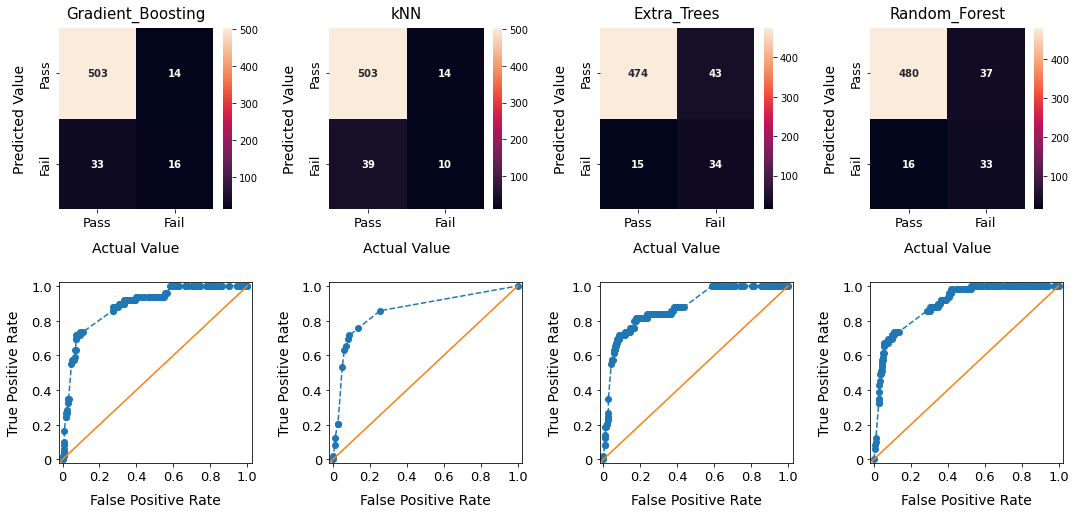

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve

# Create a grid of subplots with 2 rows and 4 columns
fig, ax = plt.subplots(2, 4, figsize=(18, 8))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

#confusion matrix
# Loop over the specific models to plot confusion matrices
for i, name in enumerate(specific_models):
    # Predict the test set results
    y_pred = models[name].best_estimator_.predict(X_test)
    
    # Compute the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot the confusion matrix using a heatmap
    sns.heatmap(cm, annot=True, annot_kws={"size": 10, "weight": "bold"}, fmt='g', ax=ax[0, i])
    
    ticks = ['Pass', 'Fail']
    ax[0, i].set_yticklabels(ticks, fontsize=13)
    ax[0, i].set_xticklabels(ticks, fontsize=13)
    ax[0, i].set_xlabel('Actual Value', labelpad=12, fontsize=14)
    ax[0, i].set_ylabel('Predicted Value', labelpad=12, fontsize=14)
    ax[0, i].set_title(specific_models[i], y=1.02, fontsize=15)

# roc curve
# Loop over the specific models to plot ROC curves
for i, name in enumerate(specific_models):
    # Predict the probability of the positive class
    probs = models[name].best_estimator_.predict_proba(X_test)
    probs = probs[:, 1]  # Keep probabilities for the positive class
    
    # Compute ROC curve
    rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, probs)
    
    # Plot ROC curve
    ax[1, i].plot(rf_fpr, rf_tpr, '--o')
    ax[1, i].plot([-0.02, 1.0], [-0.02, 1.0], '-')
    
    ticks = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
    ax[1, i].set_xticks(ticks)
    ax[1, i].set_xticklabels(ticks, fontsize=13)

    ax[1, i].set_yticks(ticks)
    ax[1, i].set_yticklabels(ticks, fontsize=13)

    ax[1, i].set_xlim(-0.02, 1.025)
    ax[1, i].set_ylim(-0.02, 1.025)

    ax[1, i].set_xlabel('False Positive Rate', fontsize=14, labelpad=10)
    ax[1, i].set_ylabel('True Positive Rate', fontsize=14, labelpad=10)


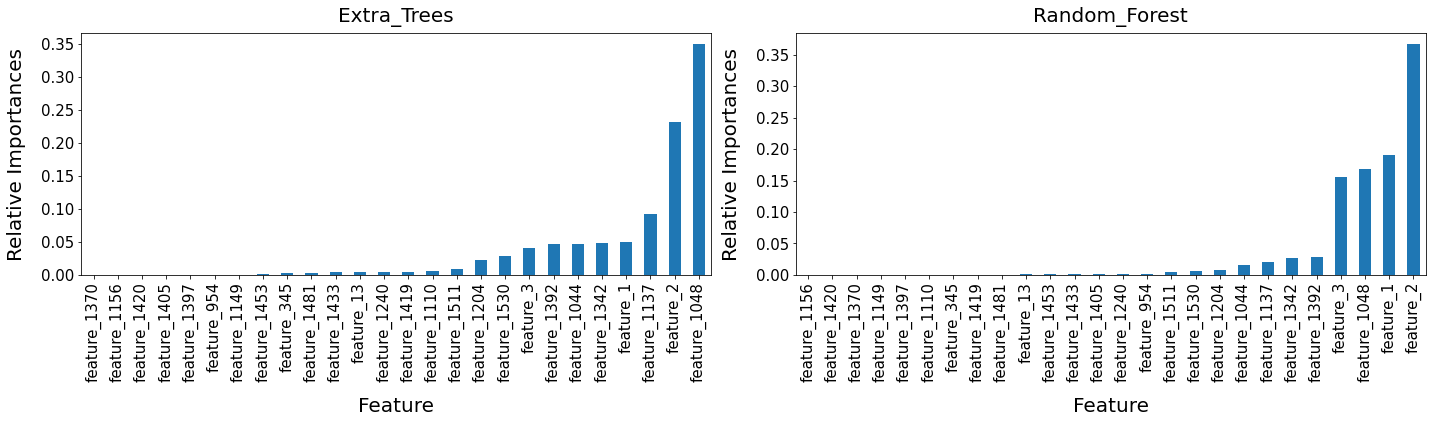

In [50]:
import matplotlib.pyplot as plt
import pandas as pd

# Feature Importance
# Create a single row of subplots with two columns
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

# Loop over the specified models to plot feature importances
for i, name in enumerate(['Extra_Trees', 'Random_Forest']):
    # Retrieve the best model
    best_model = models[name].best_estimator_
    
    # Calculate and sort feature importances
    feature_importances = pd.Series(best_model.feature_importances_,
                                    index=data_for_predictions.columns[:-1]).sort_values(ascending=True)

    # Plot feature importances as a bar chart
    feature_importances.plot(kind='bar', fontsize=15, ax=ax[i])
    ax[i].set_xlabel('Feature', labelpad=15, fontsize=20)
    ax[i].set_ylabel('Relative Importances', labelpad=15, fontsize=20)
    ax[i].set_title(name, y=1.02, fontsize=20)

plt.tight_layout()
plt.show()


## Finding the best model based on the F1-score

In [51]:
which_algorithm = results[results['F1-score']==results['F1-score'].max()]['Classifier']
best_model_method_1 = best_estimator[which_algorithm.values[0]]

results[results['F1-score']==results['F1-score'].max()]

,Classifier,Accuracy,Precision,Recall,ROC-AUC,F1-score
4,Random_Forest,89.56 $\pm$ 2.02,42.32 $\pm$ 7.07,67.14 $\pm$ 13.54,88.55 $\pm$ 4.03,53.3 $\pm$ 9.03


In [52]:
parameters = {'max_leaf_nodes': [i for i in range(2,10)],
              'max_depth': [i for i in range(2,10)]}
    
#Extra Trees
GD_ET = GridSearchCV(ExtraTreesClassifier(),
                     param_grid=parameters, 
                     scoring='f1')


GD_ET.fit(X_train,y_train)
model_without_weights = GD_ET.best_estimator_

In [53]:
data_method_predictions = data_for_predictions.copy()

In [54]:
predictions_without_weights = model_without_weights.predict(X)
data_method_predictions["Pred. without weights"] = predictions_without_weights

predictions_method_1 = best_model_method_1.predict(X)
data_method_predictions["Pred. Method 1"] = predictions_method_1

In [55]:
from sklearn.metrics import classification_report

print('Using the principle of method 1')
print()
print(classification_report(data_method_predictions.Class,data_method_predictions["Pred. Method 1"]))
print('-'*60)
print('-'*60)
print()
print('Best estimator of method 1 without weights')
print()
print(classification_report(data_method_predictions.Class,data_method_predictions["Pred. without weights"]))

Using the principle of method 1

              precision    recall  f1-score   support

           0       0.97      0.93      0.95      1572
           1       0.46      0.70      0.56       143

    accuracy                           0.91      1715
   macro avg       0.72      0.81      0.75      1715
weighted avg       0.93      0.91      0.92      1715

------------------------------------------------------------
------------------------------------------------------------

Best estimator of method 1 without weights

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      1572
           1       0.65      0.15      0.25       143

    accuracy                           0.92      1715
   macro avg       0.79      0.57      0.60      1715
weighted avg       0.90      0.92      0.90      1715



In [56]:
parameters = {'penalty':['l1','l2'],
              'C': [0.001, 0.01, 0.1, 1]}
# Logistic Regression
GD_LR = GridSearchCV(LogisticRegression(solver='liblinear'),
                        param_grid=parameters, 
                        scoring='f1')

#Decision Trees
parameters = {'max_leaf_nodes': [i for i in range(2,10)],
              'max_depth': [i for i in range(2,10)]}
    
GD_DT = GridSearchCV(DecisionTreeClassifier(),
                     param_grid=parameters, 
                     scoring='f1')

#Extra Trees
GD_ET = GridSearchCV(ExtraTreesClassifier(),
                     param_grid=parameters, 
                     scoring='f1')

#Random Forest
GD_RF = GridSearchCV(RandomForestClassifier(),
                     param_grid=parameters, 
                     scoring='f1')

#Gradient Boosting
GD_GB = GridSearchCV(GradientBoostingClassifier(),
                     param_grid=parameters, 
                     scoring='f1')

#k-NN
parameters = {'n_neighbors': [i for i in range(5,35,5)]}
GD_kNN = GridSearchCV(KNeighborsClassifier(),
                      param_grid=parameters, 
                      scoring='f1')


models = {'Logistic_Regression': GD_LR,
          'kNN': GD_kNN,
          'Decision_Trees': GD_DT,
          'Extra_Trees': GD_ET,
          'Random_Forest': GD_RF,
          'Gradient_Boosting': GD_GB}

In [57]:
import random

size = [1,1.5,2,2.5,3,3.5,5,7.5,10]

accuracy_per_size, precision_per_size, recall_per_size = [], [], []
roc_auc_per_size, f1_per_size = [], []
best_estimator_per_size = []

experiment, classes_size = [], []

print('-'*35)
for s in size:
    print('Class Pass ->', s, ': 1 <- Class Fail')
    print()
    ind_class_1 = data_for_predictions[data_for_predictions.Class==1].index.tolist()
    ind_class_0 = random.choices(data_for_predictions[data_for_predictions.Class==0].index, k=int(s*len(ind_class_1)))
    which_ind = ind_class_1 + ind_class_0
    
    random.shuffle(which_ind)
    
    X, y = data_for_predictions.iloc[which_ind,:-1], data_for_predictions.iloc[which_ind,-1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    
    classes_size.append(round((y.value_counts()/y.count())*100,2).values)
    
    results_col = ['Classifier', 'Accuracy', 'Precision', 'Recall', 'ROC-AUC', 'F1-score']
    results = pd.DataFrame(columns=results_col)

    l = 0

    accuracy_models_opt, precision_models_opt, recall_models_opt = [], [], []
    roc_auc_models_opt, f1_score_models_opt = [], []
    best_estimator = []
    
    for name, model in models.items():
        print(name)
        model.fit(X_train,y_train)
        
        best_estimator.append(model.best_estimator_)
    
        accuracy = cross_val_score(model.best_estimator_, X, y, cv=10, scoring='accuracy')
        accuracy_models_opt.append(accuracy)    
        precision = cross_val_score(model.best_estimator_, X, y, cv=10, scoring='precision')
        precision_models_opt.append(precision)
        recall = cross_val_score(model.best_estimator_, X, y, cv=10, scoring='recall')
        recall_models_opt.append(recall)
        roc_auc = cross_val_score(model.best_estimator_, X, y, cv=10, scoring='roc_auc')
        roc_auc_models_opt.append(roc_auc)
        f1 = cross_val_score(model.best_estimator_, X, y, cv=10, scoring='f1')
        f1_score_models_opt.append(roc_auc)
    
        results.loc[l] = [name,
                          '%s $\pm$ %s' %(round(accuracy.mean()*100,2),round(accuracy.std()*100,2)),
                          '%s $\pm$ %s' %(round(precision.mean()*100,2),round(precision.std()*100,2)),
                          '%s $\pm$ %s' %(round(recall.mean()*100,2),round(recall.std()*100,2)),
                          '%s $\pm$ %s' %(round(roc_auc.mean()*100,2),round(roc_auc.std()*100,2)),
                          '%s $\pm$ %s' %(round(f1.mean()*100,2),round(f1.std()*100,2))]
        l += 1
        
    experiment.append(results)
    
    best_estimator_per_size.append(best_estimator)
    
    accuracy_per_size.append(accuracy_models_opt)
    precision_per_size.append(precision_models_opt)
    recall_per_size.append(recall_models_opt)
    roc_auc_per_size.append(roc_auc_models_opt)
    f1_per_size.append(f1_score_models_opt)
    
    print('-'*35)

-----------------------------------
Class Pass -> 1 : 1 <- Class Fail

Logistic_Regression
kNN
Decision_Trees
Extra_Trees
Random_Forest
Gradient_Boosting
-----------------------------------
Class Pass -> 1.5 : 1 <- Class Fail

Logistic_Regression
kNN
Decision_Trees
Extra_Trees
Random_Forest
Gradient_Boosting
-----------------------------------
Class Pass -> 2 : 1 <- Class Fail

Logistic_Regression
kNN
Decision_Trees
Extra_Trees
Random_Forest
Gradient_Boosting
-----------------------------------
Class Pass -> 2.5 : 1 <- Class Fail

Logistic_Regression
kNN
Decision_Trees
Extra_Trees
Random_Forest
Gradient_Boosting
-----------------------------------
Class Pass -> 3 : 1 <- Class Fail

Logistic_Regression
kNN
Decision_Trees
Extra_Trees
Random_Forest
Gradient_Boosting
-----------------------------------
Class Pass -> 3.5 : 1 <- Class Fail

Logistic_Regression
kNN
Decision_Trees
Extra_Trees
Random_Forest
Gradient_Boosting
-----------------------------------
Class Pass -> 5 : 1 <- Class Fail


In [58]:
j = 0
for name, _ in models.items():
    results_per_classifier = []
    for i in range(len(experiment)):
        results_per_classifier.append([size[i],classes_size[i][0],classes_size[i][1],
                                       round(accuracy_per_size[i][j].mean()*100,2),
                                       round(precision_per_size[i][j].mean()*100,2),
                                       round(recall_per_size[i][j].mean()*100,2),
                                       round(roc_auc_per_size[i][j].mean()*100,2),
                                       round(f1_per_size[i][j].mean()*100,2)])
        
    globals()[f"{name}_results"] = pd.DataFrame(results_per_classifier, columns=['Ratio Pass:Fail','Percentage Pass',
                                                                                 'Percentage Fail','Accuracy',
                                                                                 'Precision','Recall','ROC-AUC',
                                                                                 'F1-score'])
    j+=1

In [59]:
algorithms_results = {'Logistic Regression': Logistic_Regression_results, 
                      'kNN': kNN_results, 
                      'Decision_Trees': Decision_Trees_results,
                      'Extra_Trees': Extra_Trees_results, 
                      'Random_Forest': Random_Forest_results, 
                      'Gradient_Boosting': Gradient_Boosting_results}

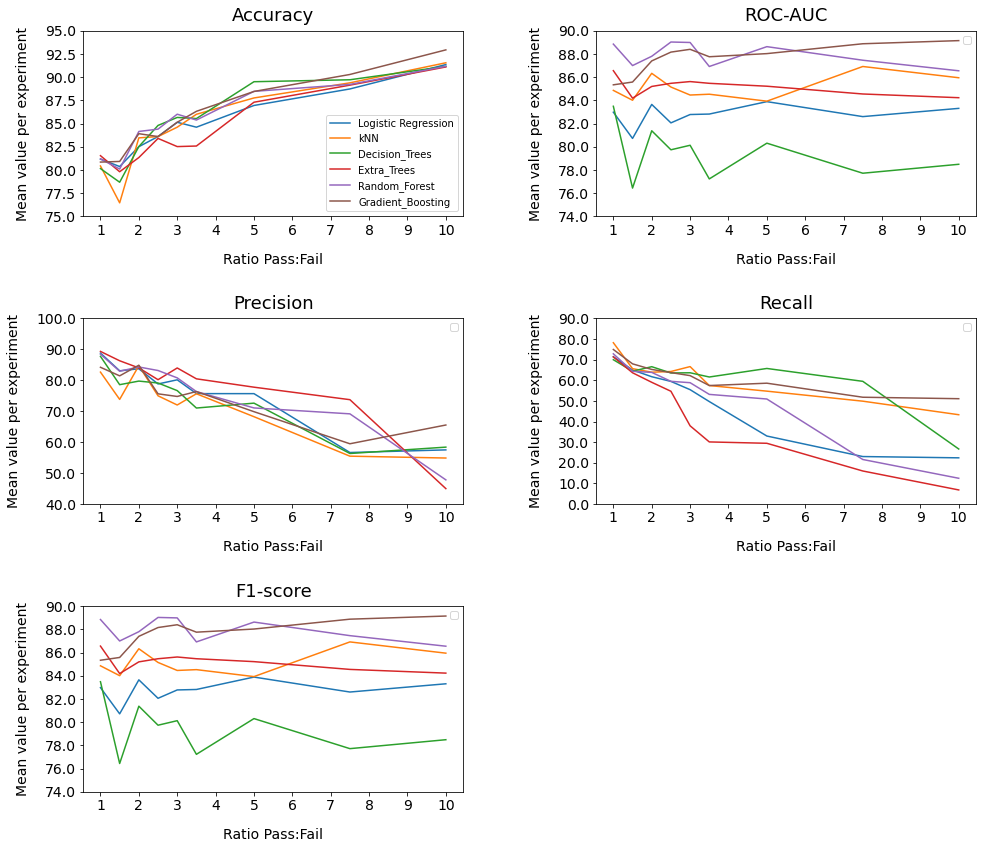

In [60]:
fig, ax = plt.subplots(3,2,figsize=(16,14))
plt.subplots_adjust(wspace=0.35,hspace=0.55)
ax[2,1].axis('off')

for algorithm_name, results in algorithms_results.items():
    results.plot(x='Ratio Pass:Fail',y='Accuracy', ax=ax[0,0], label=algorithm_name)
    results.plot(x='Ratio Pass:Fail',y='ROC-AUC', ax=ax[0,1], label=algorithm_name)
    results.plot(x='Ratio Pass:Fail',y='Precision', ax=ax[1,0], label=algorithm_name)
    results.plot(x='Ratio Pass:Fail',y='Recall', ax=ax[1,1], label=algorithm_name)
    results.plot(x='Ratio Pass:Fail',y='F1-score', ax=ax[2,0], label=algorithm_name)
    
ax[0,0].set_title('Accuracy', y=1.02, fontsize=18)
ax[0,1].set_title('ROC-AUC', y=1.02, fontsize=18)
ax[1,0].set_title('Precision', y=1.02, fontsize=18)
ax[1,1].set_title('Recall', y=1.02, fontsize=18)
ax[2,0].set_title('F1-score', y=1.02, fontsize=18)


x_ticks = [x for x in range(1,11)]
for i in range(3):
    for j in range(2):
        ax[i,j].set_xticks(x_ticks)
        ax[i,j].set_xticklabels(x_ticks, fontsize=14)
        ax[i,j].set_xlabel('Ratio Pass:Fail', labelpad=15, fontsize=14)
        ax[i,j].set_ylabel('Mean value per experiment', labelpad=15, fontsize=14)
        
        y_ticks = ax[i,j].get_yticks()
        ax[i,j].set_yticks(y_ticks)
        ax[i,j].set_yticklabels(y_ticks, fontsize=14)
        
        
ax[0,1].legend('')
ax[1,0].legend('')
ax[1,1].legend('')
ax[2,0].legend('');

## Features importance

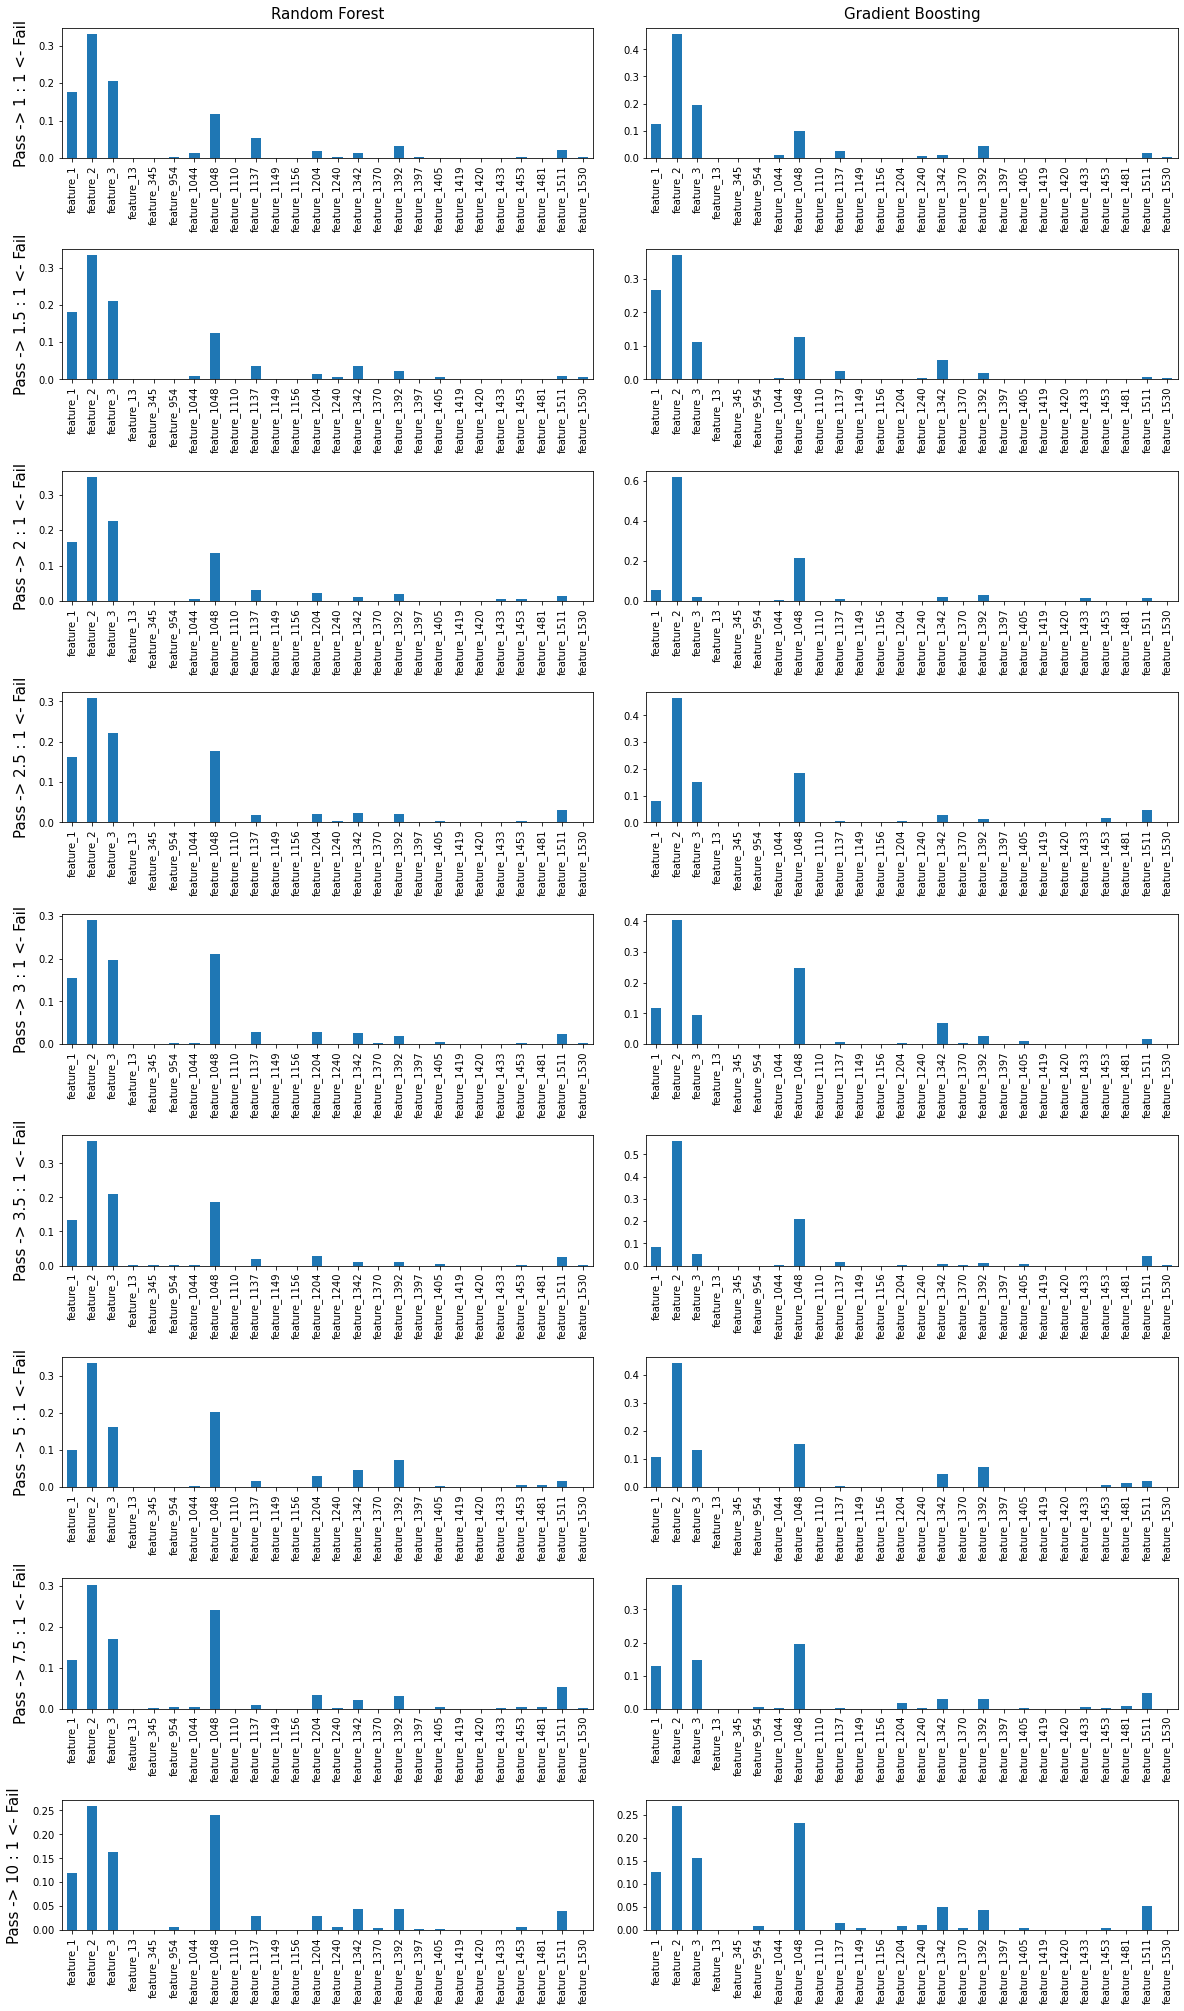

In [62]:
import matplotlib.pyplot as plt
import pandas as pd

# Create a grid of subplots with 9 rows and 2 columns
fig, ax = plt.subplots(9, 2, figsize=(20, 35))
plt.subplots_adjust(hspace=0.7, wspace=0.1)

# Loop over each size to plot feature importances for Random Forest and Gradient Boosting
for i in range(len(size)):
    # Get the best estimators for Random Forest and Gradient Boosting
    rf = best_estimator_per_size[i][4]
    gb = best_estimator_per_size[i][5]
    
    best_model = [rf, gb]
    
    for j in range(2):
        # Calculate feature importances for the current model
        feature_importances = pd.Series(
            best_model[j].feature_importances_,
            index=data_for_predictions.columns[:-1]
        )

        # Plot feature importances as a bar chart
        feature_importances.plot(kind='bar', fontsize=10, ax=ax[i, j])
        
        # Label the y-axis for the Random Forest plot
        if j == 0:
            ax[i, j].set_ylabel(f'Pass -> {size[i]} : 1 <- Fail', labelpad=10, fontsize=15)
        
# Set titles for the top row subplots
ax[0, 0].set_title('Random Forest', y=1.02, fontsize=15)
ax[0, 1].set_title('Gradient Boosting', y=1.02, fontsize=15)

plt.show()


In [63]:
searching_optimal_f1, store_algorithm = [], []
for algorithm_name, results in algorithms_results.items():
    searching_optimal_f1.append(results['F1-score'].values)
    
algorithm, exp_sample = np.where(np.array(searching_optimal_f1)==np.array(searching_optimal_f1).max())

best_model_method_2 = best_estimator_per_size[exp_sample[0]][algorithm[0]]
best_model_method_2

GradientBoostingClassifier(max_depth=5, max_leaf_nodes=9)

To find the best model

In [64]:
print('The best estimator is given by %s.' %best_model_method_2)
print()
print('The ratio is Class Pass -> %s : 1 <- Class Fail' %size[exp_sample[0]])

The best estimator is given by GradientBoostingClassifier(max_depth=5, max_leaf_nodes=9).

The ratio is Class Pass -> 10 : 1 <- Class Fail


In [65]:
predictions_method_2 = best_model_method_2.predict(data_for_predictions.iloc[:,:-1])
data_method_predictions["Pred. Method 2"] = predictions_method_2



Conclusions:

This method primarily served as an experiment to examine the impact of the majority class size on the results. Precision and recall decrease as the size of the majority class increases. While some models show a decline in the F1-score as the majority class sample grows, the GradientBoostingClassifier, the optimal algorithm, remains stable. The feature importances reveal that the continuous features and feature_1048 are significant independent variables for the model.

In [66]:
row_of_columns = data_for_predictions[data_for_predictions.columns[:-1]].corrwith(data_for_predictions.Class, method='kendall').sort_values(ascending=False).index.tolist()
row_of_columns

['feature_1048',
 'feature_2',
 'feature_1204',
 'feature_1392',
 'feature_3',
 'feature_1342',
 'feature_1511',
 'feature_1',
 'feature_1405',
 'feature_1453',
 'feature_1370',
 'feature_1240',
 'feature_1156',
 'feature_954',
 'feature_1149',
 'feature_1397',
 'feature_1420',
 'feature_1110',
 'feature_1481',
 'feature_345',
 'feature_1419',
 'feature_13',
 'feature_1433',
 'feature_1530',
 'feature_1044',
 'feature_1137']

## reduce the dimensionality

In [67]:
from sklearn.decomposition import FactorAnalysis

fa = FactorAnalysis(n_components=len(data_for_predictions[row_of_columns]))
fa.fit_transform(data_for_predictions[row_of_columns])

array([[ 0.07270904, -0.3500975 , -0.15344988, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.63152488,  0.26384258, -0.60607979, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.04152777, -0.35491067, -0.14272844, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.23993697, -0.2725738 , -0.19494719, ...,  0.        ,
         0.        ,  0.        ],
       [-0.14408734,  0.16878662,  0.06980394, ...,  0.        ,
         0.        ,  0.        ],
       [-0.44246246, -0.82040269, -0.15803061, ...,  0.        ,
         0.        ,  0.        ]])

In [68]:
m = fa.components_

m1 = m**2
m2 = np.sum(m1,axis=1)

components_var = []
for i in range(len(m2)):
    components_var.append((m2[i]*100)/np.sum(m2))
# Calculate the explained variance    

In [69]:
components_distr_features = pd.Series(components_var, index=row_of_columns).sort_values(ascending=False)
components_distr_features
# Sorting the values 

feature_1048    36.171794
feature_2       31.360822
feature_1392    16.555616
feature_1204    10.110742
feature_3        2.649714
feature_1342     0.924589
feature_1511     0.915961
feature_1        0.634022
feature_1405     0.239875
feature_1453     0.137076
feature_1370     0.126270
feature_1240     0.057310
feature_1156     0.045816
feature_954      0.032289
feature_1149     0.021241
feature_1397     0.015949
feature_1420     0.000915
feature_1110     0.000000
feature_1481     0.000000
feature_345      0.000000
feature_1419     0.000000
feature_13       0.000000
feature_1433     0.000000
feature_1530     0.000000
feature_1044     0.000000
feature_1137     0.000000
dtype: float64

In [70]:
cumulative_distributions = []
for i, x in enumerate(components_distr_features.values):
    summa = np.array(components_distr_features.values[:i+1]).sum()
    cumulative_distributions.append(summa)

In [71]:
cumulative_distributions

[36.17179385150459,
 67.53261548328545,
 84.08823178461729,
 94.19897409825596,
 96.84868812952837,
 97.77327696590744,
 98.68923779186424,
 99.32325935292491,
 99.56313456748751,
 99.70021087384019,
 99.82648067081269,
 99.88379092107662,
 99.92960732274885,
 99.9618959227064,
 99.9831365675868,
 99.99908520585745,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0]

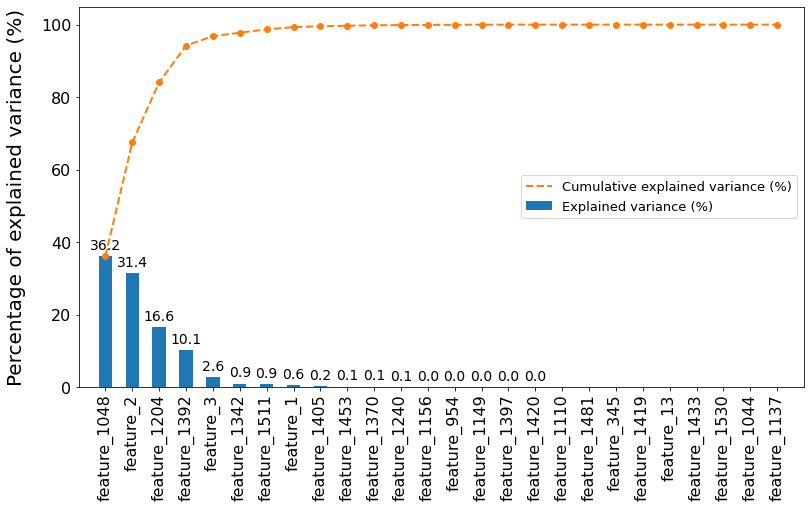

In [72]:
fig, ax = plt.subplots(1,1,figsize=(13,7))

pos = np.arange(len(cumulative_distributions))
components_distr_features.plot.bar(ax=ax, width=0.5, color='tab:blue', label='Explained variance (%)')
ax.plot(pos, cumulative_distributions, color='tab:orange', ls='--', 
        linewidth=2, label='Cumulative explained variance (%)')
ax.scatter(pos, cumulative_distributions, color='tab:orange')

ax.legend(loc='center right', fontsize=13)

ax.set_xlim(-1,len(row_of_columns))
ax.set_xticks(pos)
ax.set_xticklabels(row_of_columns, fontsize=16, rotation=90)
yticks = np.arange(0,120,20)
ax.set_yticks(yticks)
ax.set_yticklabels(yticks, fontsize=16)

ax.set_ylabel('Percentage of explained variance (%)', fontsize=20, labelpad=15)

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    if height!=0:
        ax.text(x+width-0.25, y+height+3, '{:.1f}'.format(height), 
                horizontalalignment='center', verticalalignment='center', fontsize=14);

In [73]:
number_of_components = 1
summa = 0
i = 0
while summa<80:
    summa = summa + cumulative_distributions[i]
    i+=1
    
number_of_components = number_of_components + i

print('I must use %s components.' %number_of_components)

I must use 3 components.


So i apply the 80% of the threshold and choose the different components which are: feature_1048, feature_2, feature_1204

In [74]:
fa = FactorAnalysis(n_components=number_of_components)
X_fa = fa.fit_transform(data_for_predictions[row_of_columns])

data_fa = pd.DataFrame(X_fa, columns=["Component_%s" %i for i in range(1,number_of_components+1)])
data_fa['Class'] = data_for_predictions.Class
data_fa

,Component_1,Component_2,Component_3,Class
0,0.144000,-0.718679,-0.174838,0
1,-0.093014,0.473372,-0.171275,0
2,0.081656,-0.710282,-0.166311,0
3,-0.688154,-0.074959,0.030982,0
4,1.577287,2.317222,-0.438967,0
...,...,...,...,...
1710,-0.921735,0.480690,0.114562,0
1711,0.454684,0.278949,-0.132857,0
1712,0.494875,-0.645119,-0.205464,0
1713,-0.241380,0.634526,-0.029224,0


## Data Splitting

In [75]:
X, y = data_fa.iloc[:,:-1], data_fa.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [76]:
parameters = {'penalty':['l1','l2'],
              'C': [0.001, 0.01, 0.1, 1]}
# Logistic Regression
GD_LR = GridSearchCV(LogisticRegression(solver='liblinear'),
                        param_grid=parameters, 
                        scoring='f1')

#Decision Trees
parameters = {'max_leaf_nodes': [i for i in range(2,10)],
              'max_depth': [i for i in range(2,10)]}
    
GD_DT = GridSearchCV(DecisionTreeClassifier(class_weight="balanced"),
                     param_grid=parameters, 
                     scoring='f1')

#Extra Trees
GD_ET = GridSearchCV(ExtraTreesClassifier(class_weight="balanced"),
                     param_grid=parameters, 
                     scoring='f1')

#Random Forest
GD_RF = GridSearchCV(RandomForestClassifier(class_weight="balanced"),
                     param_grid=parameters, 
                     scoring='f1')

#Gradient Boosting
GD_GB = GridSearchCV(GradientBoostingClassifier(),
                     param_grid=parameters, 
                     scoring='f1')

#k-NN
parameters = {'n_neighbors': [i for i in range(5,35,5)]}
GD_kNN = GridSearchCV(KNeighborsClassifier(),
                      param_grid=parameters, 
                      scoring='f1')


models = {'Logistic_Regression': GD_LR,
          'kNN': GD_kNN,
          'Decision_Trees': GD_DT,
          'Extra_Trees': GD_ET,
          'Random_Forest': GD_RF,
          'Gradient_Boosting': GD_GB}

In [77]:
results_col = ['Classifier', 'Accuracy', 'Precision', 'Recall', 'ROC-AUC', 'F1-score']
results = pd.DataFrame(columns=results_col)

l = 0

accuracy_models_opt, precision_models_opt, recall_models_opt = [], [], []
roc_auc_models_opt, f1_score_models_opt = [], []
best_estimator = {}

for name, model in models.items():
    print(name)
    model.fit(X_train,y_train)
    
    accuracy = cross_val_score(model.best_estimator_, X, y, cv=10, scoring='accuracy')
    accuracy_models_opt.append(accuracy)    
    precision = cross_val_score(model.best_estimator_, X, y, cv=10, scoring='precision')
    precision_models_opt.append(precision)
    recall = cross_val_score(model.best_estimator_, X, y, cv=10, scoring='recall')
    recall_models_opt.append(recall)
    roc_auc = cross_val_score(model.best_estimator_, X, y, cv=10, scoring='roc_auc')
    roc_auc_models_opt.append(roc_auc)
    f1 = cross_val_score(model.best_estimator_, X, y, cv=10, scoring='f1')
    f1_score_models_opt.append(roc_auc)
    
    best_estimator[name] = model.best_estimator_
    
    results.loc[l] = [name,
                      '%s $\pm$ %s' %(round(accuracy.mean()*100,2),round(accuracy.std()*100,2)),
                      '%s $\pm$ %s' %(round(precision.mean()*100,2),round(precision.std()*100,2)),
                      '%s $\pm$ %s' %(round(recall.mean()*100,2),round(recall.std()*100,2)),
                      '%s $\pm$ %s' %(round(roc_auc.mean()*100,2),round(roc_auc.std()*100,2)),
                      '%s $\pm$ %s' %(round(f1.mean()*100,2),round(f1.std()*100,2))]
    l += 1

Logistic_Regression
kNN
Decision_Trees
Extra_Trees
Random_Forest
Gradient_Boosting


In [78]:
results

,Classifier,Accuracy,Precision,Recall,ROC-AUC,F1-score
0,Logistic_Regression,91.78 $\pm$ 0.92,56.33 $\pm$ 23.73,14.05 $\pm$ 5.61,77.77 $\pm$ 7.49,22.03 $\pm$ 8.49
1,kNN,92.13 $\pm$ 0.95,65.78 $\pm$ 23.29,24.52 $\pm$ 8.6,83.94 $\pm$ 5.23,33.36 $\pm$ 8.1
2,Decision_Trees,90.73 $\pm$ 1.32,46.22 $\pm$ 5.7,61.48 $\pm$ 9.04,78.04 $\pm$ 4.0,52.42 $\pm$ 6.33
3,Extra_Trees,90.67 $\pm$ 1.36,44.42 $\pm$ 5.53,64.33 $\pm$ 8.91,77.84 $\pm$ 6.68,51.78 $\pm$ 5.83
4,Random_Forest,90.61 $\pm$ 1.3,44.81 $\pm$ 5.53,62.9 $\pm$ 8.8,82.58 $\pm$ 4.57,53.01 $\pm$ 6.18
5,Gradient_Boosting,91.95 $\pm$ 1.5,54.15 $\pm$ 19.37,28.0 $\pm$ 13.14,86.8 $\pm$ 3.1,35.69 $\pm$ 14.21


In [79]:
# Find the top 4 best model
metrics_used = ['Accuracy', 'Precision', 'Recall', 'F1-score']

specific_models = []

for x in metrics_used:
    which_algorith = results.sort_values(x, ascending=False).iloc[0,0]
    if x!='Accuracy':
        if which_algorith in specific_models:
            i=1
            while which_algorith in specific_models:
                which_algorith = results.sort_values(x, ascending=False).iloc[i,0]
                if which_algorith in specific_models:
                    i+=1
                else:
                    specific_models.append(which_algorith)
                    break
        else:
            specific_models.append(which_algorith)
    else:
        specific_models.append(which_algorith)
        

specific_models

['kNN', 'Logistic_Regression', 'Extra_Trees', 'Random_Forest']

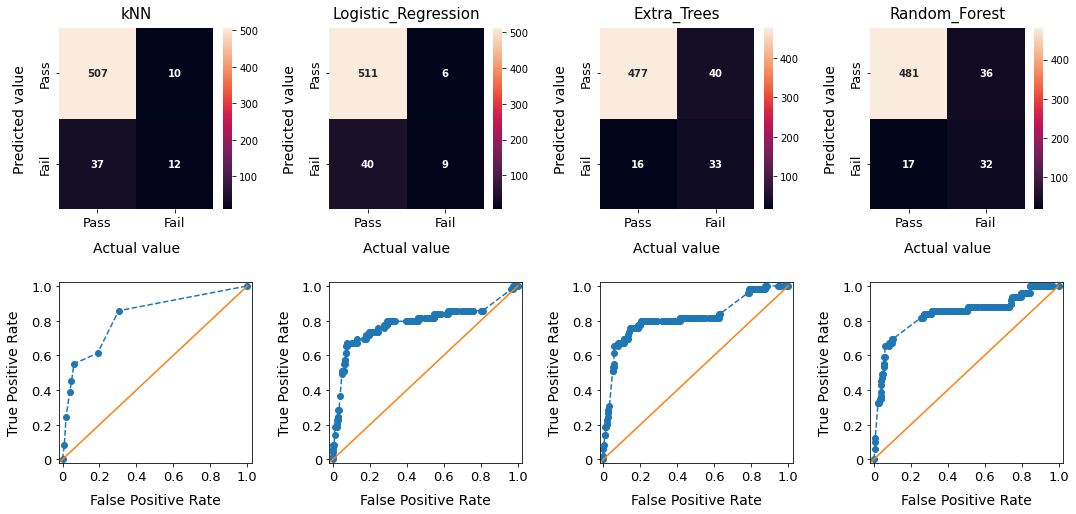

In [80]:
fig, ax = plt.subplots(2, 4, figsize=(18,8))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

# Confusion Matrix                              
i = 0
for name in specific_models:
    y_pred = models[name].best_estimator_.predict(X_test)
    cm = confusion_matrix(y_test,y_pred)

    sns.heatmap(cm, annot=True, annot_kws={"size": 10, "weight": "bold"}, fmt='g', ax=ax[0,i])
    
    ticks=['Pass', 'Fail']
    ax[0,i].set_yticklabels(ticks, fontsize=13)
    ax[0,i].set_xticklabels(ticks, fontsize=13)
    ax[0,i].set_xlabel('Actual value', labelpad=12, fontsize=14)
    ax[0,i].set_ylabel('Predicted value', labelpad=12, fontsize=14)
    
    ax[0,i].set_title(specific_models[i], y=1.02, fontsize=15)
    i+=1
    
# ROC curve                                                 
i = 0
for name in specific_models:
    probs = models[name].best_estimator_.predict_proba(X_test) 
    probs = probs[:, 1] 
    rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, probs)
    
    ax[1,i].plot(rf_fpr, rf_tpr, '--o')
    ax[1,i].plot([-0.02,1.],[-0.02,1.], '-')
    
    ticks = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
    ax[1,i].set_xticks(ticks)
    ax[1,i].set_xticklabels(ticks, fontsize=13)

    ax[1,i].set_yticks(ticks)
    ax[1,i].set_yticklabels(ticks, fontsize=13)

    ax[1,i].set_xlim(-0.02,1.025)
    ax[1,i].set_ylim(-0.02,1.025)

    ax[1,i].set_xlabel('False Positive Rate', fontsize=14, labelpad=10)
    ax[1,i].set_ylabel('True Positive Rate', fontsize=14, labelpad=10)
    
    i+=1;

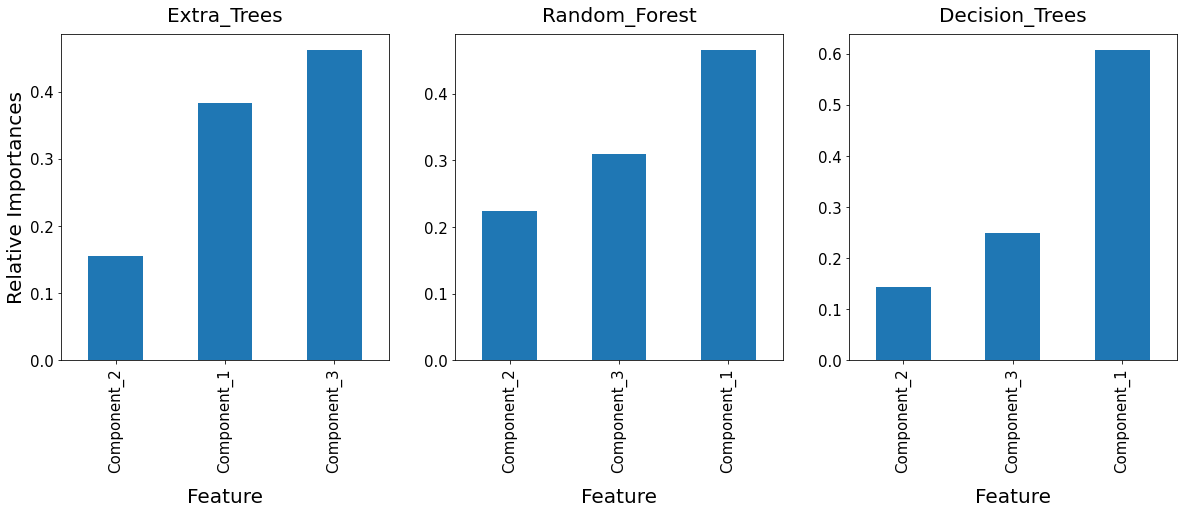

In [82]:
# Importance feature
fig, ax = plt.subplots(1,3,figsize=(20,6))

for i, name in enumerate(['Extra_Trees','Random_Forest','Decision_Trees']):
    best_model = models[name].best_estimator_
    feature_importances = pd.Series(best_model.feature_importances_,
                                    data_fa.columns[:-1]).sort_values(ascending=True)

    feature_importances.plot(kind='bar', fontsize=15, ax=ax[i])
    ax[i].set_xlabel('Feature', labelpad=15, fontsize=20)
    ax[i].set_title(name, y=1.02, fontsize=20)
    if i==0:
        ax[i].set_ylabel('Relative Importances', fontsize=20);

In [83]:
which_algorithm = results[results['F1-score']==results['F1-score'].max()]['Classifier']
best_model_method_3 = best_estimator[which_algorithm.values[0]]

results[results['F1-score']==results['F1-score'].max()]

,Classifier,Accuracy,Precision,Recall,ROC-AUC,F1-score
4,Random_Forest,90.61 $\pm$ 1.3,44.81 $\pm$ 5.53,62.9 $\pm$ 8.8,82.58 $\pm$ 4.57,53.01 $\pm$ 6.18


In [84]:
predictions_method_3 = best_model_method_3.predict(X)
data_method_predictions["Pred. Method 3"] = predictions_without_weights

### Conclude


Factor Analysis is a dimensionality reduction technique primarily used for categorical features. I transformed the first four features because they were sufficient to surpass the 80% threshold. The Decision Trees model performed the best. However, the confusion matrix and F1-score indicate that many predicted values were misclassified.

## Analyzing the different methods

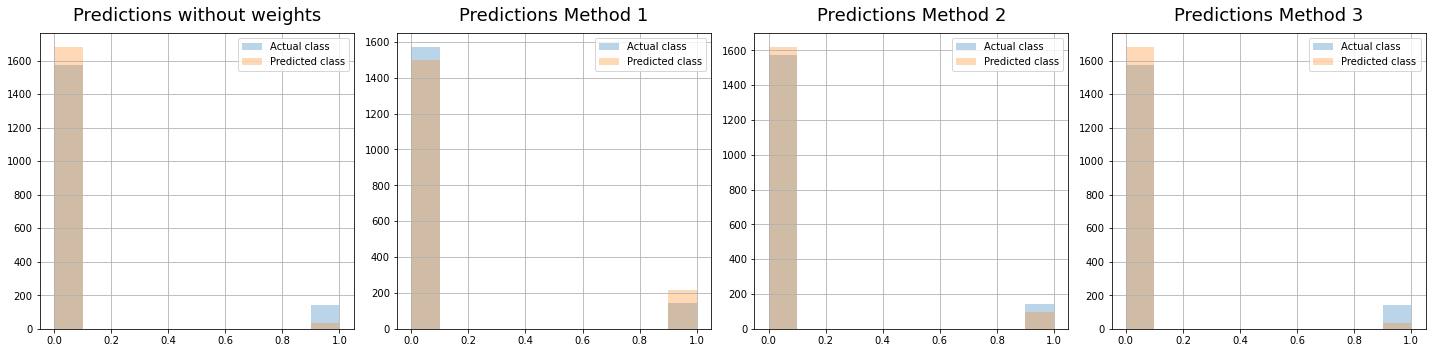

In [85]:
import matplotlib.pyplot as plt

# Create a row of subplots with 1 row and 4 columns
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

# Plot histograms for each prediction method alongside actual classes

# Predictions without weights
data_method_predictions.Class.hist(ax=ax[0], alpha=0.3, label='Actual class')
data_method_predictions['Pred. without weights'].hist(ax=ax[0], alpha=0.3, label='Predicted class')
ax[0].set_title('Predictions without weights', y=1.02, fontsize=18)
ax[0].legend()

# Predictions Method 1
data_method_predictions.Class.hist(ax=ax[1], alpha=0.3, label='Actual class')
data_method_predictions['Pred. Method 1'].hist(ax=ax[1], alpha=0.3, label='Predicted class')
ax[1].set_title('Predictions Method 1', y=1.02, fontsize=18)
ax[1].legend()

# Predictions Method 2
data_method_predictions.Class.hist(ax=ax[2], alpha=0.3, label='Actual class')
data_method_predictions['Pred. Method 2'].hist(ax=ax[2], alpha=0.3, label='Predicted class')
ax[2].set_title('Predictions Method 2', y=1.02, fontsize=18)
ax[2].legend()

# Predictions Method 3
data_method_predictions.Class.hist(ax=ax[3], alpha=0.3, label='Actual class')
data_method_predictions['Pred. Method 3'].hist(ax=ax[3], alpha=0.3, label='Predicted class')
ax[3].set_title('Predictions Method 3', y=1.02, fontsize=18)
ax[3].legend()

plt.tight_layout()
plt.show()


In [86]:
# Create a new DataFrame with specific columns for analysis
methods_analysis = data_method_predictions[['Class', 'Pred. without weights', 
                                            'Pred. Method 1', 'Pred. Method 2', 
                                            'Pred. Method 3']]


In [87]:
# Define the columns containing predictions
columns = ['Pred. without weights', 'Pred. Method 1', 'Pred. Method 2', 'Pred. Method 3']

# Count the total number of instances for class 0 and class 1
how_many_0 = methods_analysis[methods_analysis.Class == 0]['Class'].count()
how_many_1 = methods_analysis[methods_analysis.Class == 1]['Class'].count()

# Initialize lists to store misclassification percentages for each method
perc_mis_0_to_1_per_method, perc_mis_1_to_0_per_method = [], []

# Loop through each prediction method
for x in columns:
    # Count misclassifications from class 0 to class 1
    mis_0_to_1 = methods_analysis[(methods_analysis.Class == 0) &
                                  (methods_analysis[x] == 1)][x].count()
    # Count misclassifications from class 1 to class 0
    mis_1_to_0 = methods_analysis[(methods_analysis.Class == 1) &
                                  (methods_analysis[x] == 0)][x].count()

    # Calculate the percentage of misclassifications for each case
    perc_mis_0_to_1_per_method.append(round(mis_0_to_1 / how_many_0 * 100, 2))
    perc_mis_1_to_0_per_method.append(round(mis_1_to_0 / how_many_1 * 100, 2))

    # Count correctly classified instances for class 0 and class 1
    correct_classified_0 = methods_analysis[(methods_analysis.Class == 0) &
                                            (methods_analysis[x] == 0)][x].count()
    correct_classified_1 = methods_analysis[(methods_analysis.Class == 1) &
                                            (methods_analysis[x] == 1)][x].count()

    # Print results for each method
    print('For the column', x, ':')
    print()
    print('Classified 0 but predicted to 1:', mis_0_to_1)
    print('Classified 1 but predicted to 0:', mis_1_to_0)
    print('-' * 40)


For the column Pred. without weights :

Classified 0 but predicted to 1: 12
Classified 1 but predicted to 0: 121
----------------------------------------
For the column Pred. Method 1 :

Classified 0 but predicted to 1: 116
Classified 1 but predicted to 0: 43
----------------------------------------
For the column Pred. Method 2 :

Classified 0 but predicted to 1: 29
Classified 1 but predicted to 0: 77
----------------------------------------
For the column Pred. Method 3 :

Classified 0 but predicted to 1: 12
Classified 1 but predicted to 0: 121
----------------------------------------


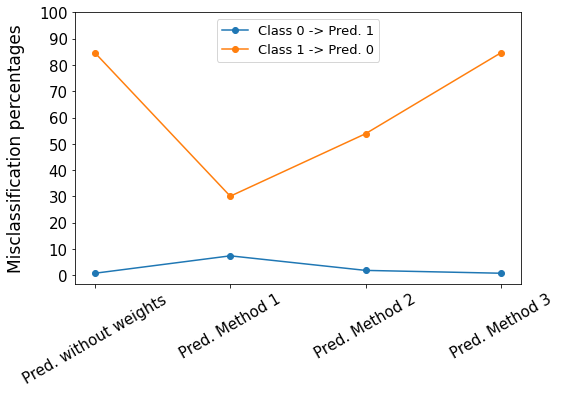

In [88]:
import matplotlib.pyplot as plt
import numpy as np

# Create a single subplot
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

# Define the positions for the x-axis labels
pos = np.arange(4)

# Plot the misclassification percentages for each method
ax.plot(pos, perc_mis_0_to_1_per_method, label='Class 0 -> Pred. 1', marker='o')
ax.plot(pos, perc_mis_1_to_0_per_method, label='Class 1 -> Pred. 0', marker='o')

# Set the x-axis ticks and labels
ax.set_xticks(pos)
ax.set_xticklabels(columns, fontsize=15, rotation=30)

# Set the y-axis ticks and labels
ax.set_yticks([i for i in range(0, 110, 10)])
ax.set_yticklabels([i for i in range(0, 110, 10)], fontsize=15)

# Set the y-axis label
ax.set_ylabel('Misclassification percentages', labelpad=14, fontsize=17)

# Add a legend
ax.legend(loc='best', fontsize=13)

# Show the plot
plt.show()


## Conclusions

In summary, I followed a specific approach to reach this section. First, I checked for duplicate columns, as most variables were binary. More than 50% of the original columns had to be removed due to duplication, resulting in a significantly smaller dataset. I then assessed the correlation between the target feature and the binary features using chi-squared and mutual information tests, which led to further reduction.

Because the target column was unbalanced, I used different methods to predict the Class feature. The same algorithms were employed in each method, with hyperparameters tuned each time. The results were compared using the F1-score. The first and second methods produced good results. I selected the model from Method 1 because it resulted in fewer misclassifications for the minority class, as shown in the last figure. With this model, I know that approximately 30% of the predicted 'Fail' class is misclassified, and the same applies to the predicted 'Pass' class with a misclassification rate of about 10%.

Before proceeding to the appendix to use the model to predict the classes for the Test.csv file, I should note that the best estimator from the models in Methods 1 and 2 needs to be run multiple times with different data splits, enhancing the hyperparameters and collecting enough statistics to ultimately select the best one.